In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from termcolor import colored

In [8]:
fpth = 'data/tunnel.csv'
time_column = 'Day'
cols_to_drop = None

df = pd.read_csv(fpth, index_col= time_column, parse_dates = True)
if cols_to_drop:
    df = df.drop(cols_to_drop, axis=1)
df.head(3)

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795


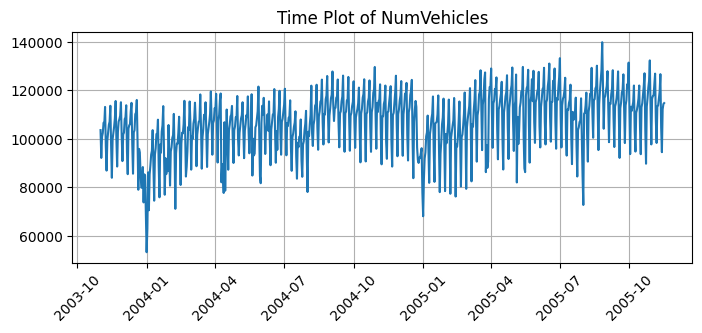

In [9]:
fig, ax = plt.subplots(figsize = (8,3))
ax.plot(df.index, df.NumVehicles)
ax.tick_params(axis="x", rotation = 45)
ax.set_title('Time Plot of NumVehicles')
ax.grid()

#### Create both Time-step & Lag features 

In [10]:
# Before creating Time-step & Lag features, check for missing dates, to understand how to create those features
startDate = df.index[0]
endDate = df.index[-1]
print(f'Start date in df: {startDate}\nEnd date in df: {endDate}')

# because we have data for each day, hence, freq = D
possible_dates = pd.date_range(start = startDate, end = endDate, freq='D')
available_dates = df.index

missing_dates = possible_dates.difference(available_dates)
print(f'Total missing dates are : {len(missing_dates)}')
if len(missing_dates)>=1:
    print('Missing dates: ', missing_dates)

Start date in df: 2003-11-01 00:00:00
End date in df: 2005-11-16 00:00:00
Total missing dates are : 0


In [11]:
# Time-step feature
# Since no missing dates, we can create Time-step features simply as below
df['Time_dummy'] = np.arange(len(df.index))

# Lag feature
df['Lag_1'] = df['NumVehicles'].shift(1)

df.dropna(inplace=True)
df.head(3)

,NumVehicles,Time_dummy,Lag_1
Day,,,
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0


FOR only_Timestep
X.shape, y.shape:  (746, 1) (746,)
Linear Regression score: 0.15207094287666223 
MSE: 131554777.10360996 
NumVehicles = 98147.4096406787 + 22.555312969675644 x Time_dummy



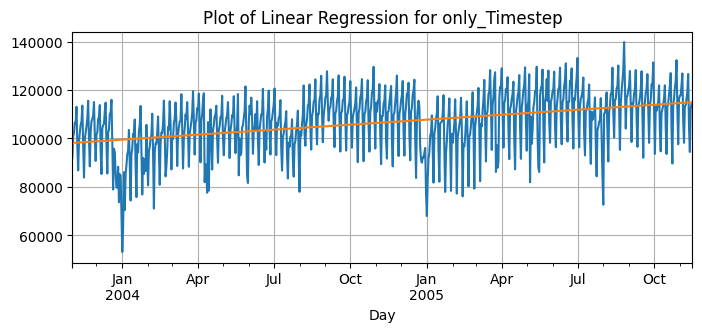

FOR only_Lag
X.shape, y.shape:  (746, 1) (746,)
Linear Regression score: 0.28391328985412134 
MSE: 111099657.1572799 
NumVehicles = 49780.624869069565 + 0.5329660641208311 x Lag_1



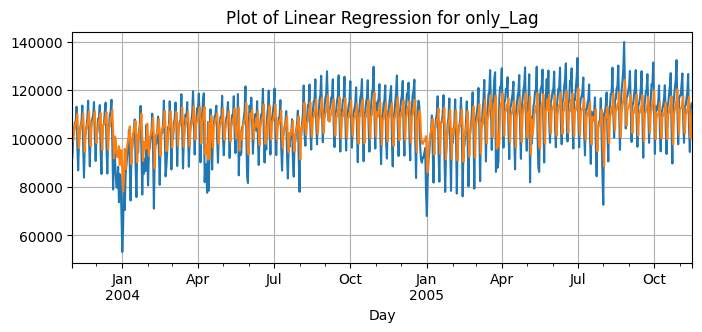

FOR Timestep + Lag
X.shape, y.shape:  (746, 2) (746,)
Linear Regression score: 0.3232188936086461 
MSE: 105001458.37825494 
NumVehicles = 54056.82413985928 + 12.448091885338814 x Time_dummy + 0.4492027007940359 x Lag_1



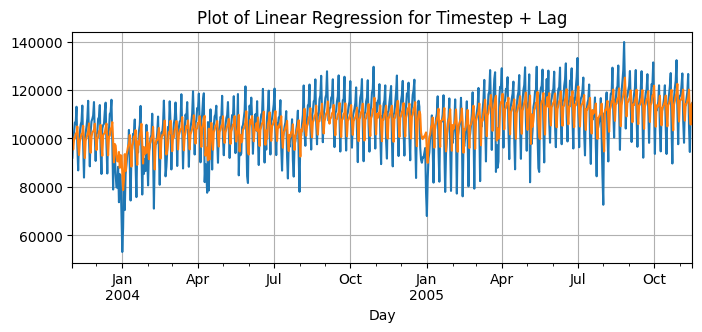

In [12]:
dep = 'NumVehicles'
#indeps = ['Time_dummy', 'Lag_1']

indeps_combinations = {
    'only_Timestep': ['Time_dummy'],
    'only_Lag': ['Lag_1'], 
    'Timestep + Lag': ['Time_dummy', 'Lag_1']
}

for case, indeps in indeps_combinations.items():
    print(colored(f'FOR {case}', 'green', attrs=['bold']))
    
    # Fit a linear regression model 
    X = df.loc[:, indeps]
    y = df.loc[:,  dep]
    print('X.shape, y.shape: ', X.shape, y.shape)
    #print('X:\n', X.head(2), '\n\ny: \n', y.head(2))
    
    # Model
    lr = LinearRegression()
    lr.fit(X,y)
    print(colored(f'Linear Regression score: {lr.score(X, y)} ', 'red', attrs=['bold']))
    
    # Predictions
    y_pred = lr.predict(X)
    
    # make preds as a dataframe
    y_pred = pd.Series(y_pred, index = X.index)
    #print('\n\nPredictions:\n', y_pred.head(2))
    print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))
    
    # Equation
    formula = f'NumVehicles = {lr.intercept_}'
    for i in range(len(indeps)):
        formula += f' + {lr.coef_[i]} x {indeps[i]}'
    
    print(colored(formula, 'red', attrs=['bold']))
    print()
    fig, ax = plt.subplots(figsize=(8,3))
    ax = y.plot()
    ax = y_pred.plot()
    ax.set_title(f'Plot of Linear Regression for {case}')
    ax.grid()
    plt.show()

I notice __a large difference in linear regression coefficients for Timestep + Lag case__. It is because scale of both variables are different.

We should use __Scaling__ where all features should have same range

FOR only_Timestep
X.shape, y.shape:  (746, 1) (746,)
Linear Regression score: 0.15207094287666223 
MSE: 131554777.10360996 
Vehicles = 106571.81903485255 + 4857.319509433654 x Time_dummy



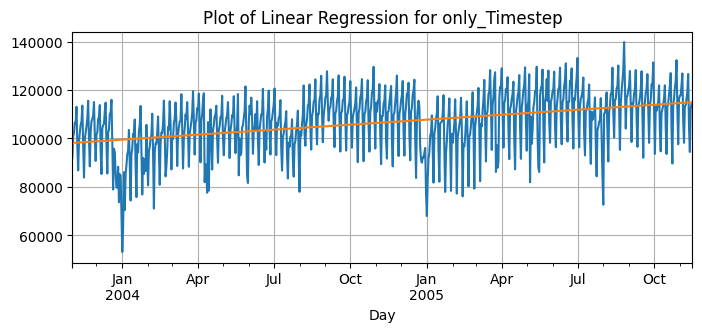

FOR only_Lag
X.shape, y.shape:  (746, 1) (746,)
Linear Regression score: 0.28391328985412134 
MSE: 111099657.1572799 
Vehicles = 106571.81903485255 + 6636.917414210817 x Lag_1



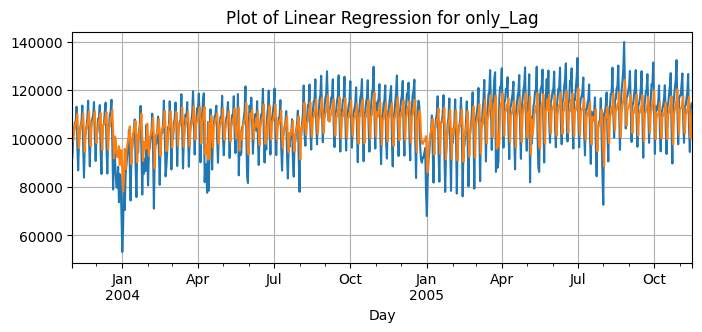

FOR Timestep + Lag
X.shape, y.shape:  (746, 2) (746,)
Linear Regression score: 0.323218893608646 
MSE: 105001458.37825495 
Vehicles = 106571.81903485255 + 2680.714723452073 x Time_dummy + 5593.829378852463 x Lag_1



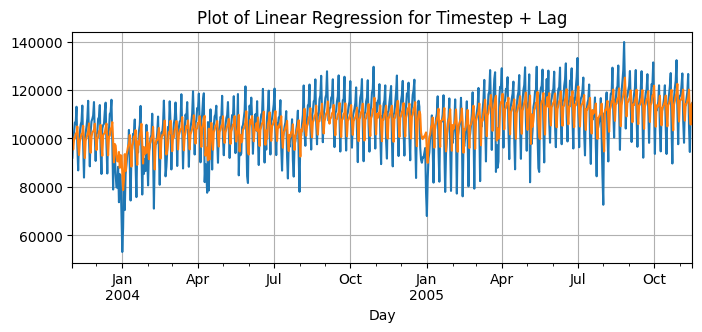

In [13]:
dep = 'NumVehicles'
#indeps = ['Time_dummy', 'Lag_1']

indeps_combinations = {
    'only_Timestep': ['Time_dummy'],
    'only_Lag': ['Lag_1'], 
    'Timestep + Lag': ['Time_dummy', 'Lag_1']
}

for case, indeps in indeps_combinations.items():
    print(colored(f'FOR {case}', 'green', attrs=['bold']))
    
    # Fit a linear regression model 
    X = df.loc[:, indeps]
    y = df.loc[:,  dep]
    print('X.shape, y.shape: ', X.shape, y.shape)
    #print('X:\n', X.head(2), '\n\ny: \n', y.head(2))
    scaler = StandardScaler()
    scaler.fit(X)
    X_tr = scaler.transform(X)
    
    # Model
    lr = LinearRegression()
    lr.fit(X_tr,y)
    print(colored(f'Linear Regression score: {lr.score(X_tr, y)} ', 'red', attrs=['bold']))
    
    # Predictions
    y_pred = lr.predict(X_tr)
    
    # make preds as a dataframe
    y_pred = pd.Series(y_pred, index = X.index)
    #print('\n\nPredictions:\n', y_pred.head(2))
    print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))
    
    # Equation
    formula = f'Vehicles = {lr.intercept_}'
    for i in range(len(indeps)):
        formula += f' + {lr.coef_[i]} x {indeps[i]}'
    
    print(colored(formula, 'red', attrs=['bold']))
    print()
    fig, ax = plt.subplots(figsize=(8,3))
    ax = y.plot()
    ax = y_pred.plot()
    ax.set_title(f'Plot of Linear Regression for {case}')
    ax.grid()
    plt.show()
